# Disaster Tweets

Initial plan is to use this notebook for data exploration and preprocessing.

In [1]:
# imports

# data
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup 

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, pipeline

# from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

# # XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

/Users/davidwalkup/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read training and test data
train_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('/Users/davidwalkup/ds-course/projects/Mod4/disaster_tweet_prediction/data/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
no_keyword = train_df.loc[train_df['keyword'].isna() == True].index
train_df['keyword'].loc[no_keyword] = 'no_keyword'

In [6]:
no_location = train_df.loc[train_df['location'].isna() == True].index
train_df['location'].loc[no_location] = 'no_location'

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [10]:
no_keyword = test_df.loc[test_df['keyword'].isna() == True].index
test_df['keyword'].loc[no_keyword] = 'no_keyword'

In [11]:
no_location = test_df.loc[test_df['location'].isna() == True].index
test_df['location'].loc[no_location] = 'no_location'

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3263 non-null   object
 2   location  3263 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [13]:
test_df.head()

,id,keyword,location,text
0,0,no_keyword,no_location,Just happened a terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan


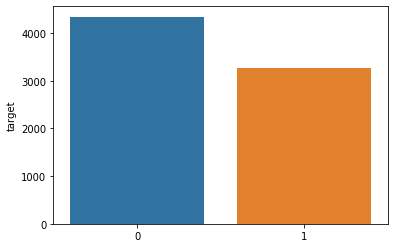

In [14]:
sns.barplot(train_df['target'].value_counts().index, train_df['target'].value_counts());

How good do I have to be to beat just saying "not a disaster" for every observation?

In [15]:
p_classes = dict(train_df['target'].value_counts(normalize=True))
naive_approach = p_classes[0]
print('Class probabilities: ', p_classes,
      '\nChance tweet is not about a real disaster: ', np.round(naive_approach, decimals = 4))

Class probabilities:  {0: 0.5703402075397347, 1: 0.4296597924602653} 
Chance tweet is not about a real disaster:  0.5703


Random sample of training data

In [16]:
train_df['text'].sample(5)

5702    I liked a @YouTube video http://t.co/FNpDJwVw1...
1600    Warne Ponting shocked by Australian collapse -...
4014    69 die in Myanmar floods 250000 affected http:...
7277    Last Second OutBid RT? http://t.co/KrNW0Wxhe5 ...
2426    Relief train carrying survivors of the deraile...
Name: text, dtype: object

In [17]:
# example for finding text in square brackets
# train_df.loc[train_df['text'].apply(lambda x: re.search(r'\[.*?\]', x)).isna() == False]

In [18]:
# example for finding retweets
# train_df['text'].loc[train_df['text'].apply(lambda x: 'rt ' in x)]

Helper function for cleaning text.

In [19]:
def text_cleaner(text):
    text = text.lower()
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    text = tokenizer.tokenize(text)
    text = [word for word in text if word not in string.punctuation]
    text = ' '.join(text)
    return text

In [20]:
train_df['text'] = train_df['text'].apply(lambda x: text_cleaner(x))

Bagging using sklearn CountVectorizer

In [21]:
count_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                   stop_words = stopwords.words('english'),
                                   ngram_range = (1, 2),
                                   binary = True)

In [22]:
train_vector_df = count_vectorizer.fit_transform(train_df['text'])

In [23]:
train_vector_df.shape

(7613, 76554)

Logistic Regression on CountVectorizer treated training data

In [24]:
# w/no cleaning: 0.5970784000653343 +/- 0.06368841665479281
# w/cleaning: 0.5979479898225941 +/- 0.06349283339951738
# w/cleaning, balanced class weight: 
clf = LogisticRegression(class_weight = 'balanced')
scores = model_selection.cross_val_score(clf, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.6110267887900876 +/- 0.06630939729733831


Multinomial Bayes on CountVectorizer treated training data

In [25]:
# w/no cleaning: 0.6596471672909543 +/- 0.033935108319165
# w/cleaning: 0.6594763720845761 +/- 0.03341037684629987
clf = MultinomialNB()
scores = model_selection.cross_val_score(clf, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.6623831170491699 +/- 0.03295889860050674


Bagging and term frequency weighting using TD-IDF vectorization

In [26]:
tf_idf = TfidfVectorizer(min_df=2,
                         max_df=0.5,
                         ngram_range=(1, 1))

In [27]:
train_tfidf_df = tf_idf.fit_transform(train_df['text'])

Logistic Regression on TF-IDF treated training data

In [28]:
# w/no cleaning: 0.6117845209530192 +/- 0.0530940957853178
# w/cleaning: 0.6116640233118774 +/- 0.054064619690216614
# w/cleaning, balanced class weight: 
clf = LogisticRegression(class_weight = 'balanced')
scores = model_selection.cross_val_score(clf, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.6385812199046155 +/- 0.049636075324394395


Multinomial Bayes on TF-IDF treated training data

In [29]:
# w/no cleaning: 0.6092126780070748 +/- 0.06534813484665665
# w/cleaning: 0.609552450352553 +/- 0.06450734863558556
clf = MultinomialNB()
scores = model_selection.cross_val_score(clf, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.6614222210215676 +/- 0.05471810258019671


In [30]:
# w/no cleaning: 0.6092126780070748 +/- 0.06534813484665665
# w/cleaning: 0.609552450352553 +/- 0.06450734863558556
clf = MultinomialNB(alpha = 0.5)
scores = model_selection.cross_val_score(clf, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

0.6625919031191195 +/- 0.0500473220403406


XGBoost on CountVectorizer treated training data

In [31]:
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                            subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vector_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

KeyboardInterrupt: 

XGBoost on TF-IDF Vectorizer treated training data

In [ ]:
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                            subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_tfidf_df, train_df["target"], cv=5, scoring="f1")
print(scores.mean(), '+/-', scores.std())

Attempting to use TensorFlow & BERT

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_df.text.values, tokenizer, max_len=160)
train_labels = train_df.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=1,
#     batch_size=16
)

In [ ]:
test_pred = model.predict(test_input)

In [ ]:
# submission['target'] = test_pred.round().astype(int)
# submission.to_csv('submission.csv', index=False)